The aim of this experiment is to assign coordinates which have no stop to a color / travel time cluster.  

# Dependencies

In [1]:
import subprocess
import pathlib
import csv
import json
import datetime
import itertools

import cartopy.crs
import cartopy.feature
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.transforms
import numpy as np
import scipy.stats
import scipy.cluster.vq
import sklearn.linear_model
import sklearn.neighbors
import cartopy.io.shapereader
import shapely.ops
import shapely.prepared
import shapely.geometry
import tueplots.bundles

# Module configuration

In [2]:
# disable the ShapelyDeprecationWarnings
# which are produced by cartopy as I'm using an old version
# as the newest cartopy requires libgeos 3.7.2 but debian bust only has 3.7.1
import warnings
warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = [18, 12]
point_size = 3

In [3]:
save = False
if save:
    point_size = 1
    plt.rcParams.update(tueplots.bundles.neurips2021(usetex=False))
    original_show = plt.show
    def save_show(*args, counter=itertools.count(), **kwargs):
        plt.savefig(f"{next(counter)}.pdf", bbox_inches="tight")
        original_show()
    plt.show = save_show

# Constants

In [4]:
TUEBINGEN_HBF_ID = '8000141'
repository_path = pathlib.Path(
    subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
    .rstrip()
    .decode())
assert repository_path.exists()
data_path = repository_path / 'dat'
assert data_path.exists()
stops_path = data_path / 'D_Bahnhof_2020_alle.CSV'
assert stops_path.exists()
trips_020522_path = data_path / 'Mo, 02.05.2022' / TUEBINGEN_HBF_ID
trips_240122_path = data_path / 'Mo, 24.01.2022' / TUEBINGEN_HBF_ID
assert trips_020522_path.exists()
assert trips_240122_path.exists()
gadmorg_path = data_path / 'gadm.org'
assert gadmorg_path.exists()
germany_shape_path = gadmorg_path / 'gadm36_DEU_0.shp'
assert germany_shape_path.exists()
german_states_shape_path = gadmorg_path / 'gadm36_DEU_1.shp'
assert german_states_shape_path.exists()

# Loading datasets

In [5]:
def load_stops(path: pathlib.Path):
    with path.open() as f:
        reader = csv.reader(f, delimiter=';')
        data = list(reader)
        return (data[0], data[1:])

def load_trip(path: pathlib.Path):
    try:
        with path.open() as f:
            return json.load(f)
    except FileNotFoundError:
        return None
    
def parse_time(time_text: str):
    hours, minutes = time_text.split(':')
    return datetime.timedelta(
        hours=int(hours), minutes=int(minutes))

def load_trips(stops_title, stops):
    trips = []

    for stop in stops:
        stop_id = stop[stops_title['EVA_NR']]
        stop_latitude = float(
            stop[stops_title['Breite']]
            .replace(',', '.'))
        stop_longitude = float(
            stop[stops_title['Laenge']]
            .replace(',', '.'))
        trip_filename = f"{stop_id}.json"
        stop_trips = (
            load_trip(trips_020522_path / trip_filename) or
            load_trip(trips_240122_path / trip_filename))

        if not stop_trips:
            # there are no trips to the stop
            continue

        stop_minimum_travel_time = min(
            parse_time(trip['travel time'])
            for trip in stop_trips)
        trips.append({
            'id': stop_id,
            'latitude': stop_latitude,
            'longitude': stop_longitude,
            'minimum_travel_time': stop_minimum_travel_time})
        
    return trips

In [6]:
stops_title, stops = load_stops(stops_path)
stops_title = {title: i for i, title in enumerate(stops_title)}
trips = load_trips(stops_title, stops)

# Required code which was introduced in experiment 002

In [7]:
# credits: https://gist.github.com/graydon/11198540
germany_rectangle = (4.98865807458, 15.4169958839, 47.1024876979, 55.183104153)

In [8]:
longitude_x = [trip['longitude'] for trip in trips]
latitude_y = [trip['latitude'] for trip in trips]
minimum_travel_time_z = [
    trip['minimum_travel_time'].total_seconds() // 60
    for trip in trips]

In [9]:
def create_colormap(hex_color_ranges, *, discret=False):
    rgb_color_ranges = [
        (lower_bound, matplotlib.colors.hex2color(hex_color))
        for lower_bound, hex_color in hex_color_ranges]
    lower_bounds, rgb_colors = zip(*rgb_color_ranges)
    red, green, blue = zip(*rgb_colors)
    return matplotlib.colors.LinearSegmentedColormap(
        '',
        segmentdata={
            'red': [(lower_bounds[i],
                     red[max(0, i-1)] if discret else red[i],
                     red[i])
                    for i in range(len(lower_bounds))],
            'green': [(lower_bounds[i],
                       green[max(0, i-1)] if discret else green[i],
                       green[i])
                    for i in range(len(lower_bounds))],
            'blue': [(lower_bounds[i],
                      blue[max(0, i-1)] if discret else blue[i],
                      blue[i])
                    for i in range(len(lower_bounds))]})


def create_colormap_absolute(hex_color_ranges, maximum, **kwargs):
    hex_color_ranges = [
        (lower_bound / maximum, hex_color)
        for lower_bound, hex_color in hex_color_ranges]
    return create_colormap(hex_color_ranges, **kwargs)

In [10]:
minimum_travel_time = min(minimum_travel_time_z)
maximum_travel_time = max(minimum_travel_time_z)

In [11]:
diverging_colors = tuple(reversed(['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']))
qualitative_colors = ('#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17', '#666666')

In [12]:
def configure_colorbar(sc, bounds, max_value):
    colorbar = plt.colorbar(sc, ticks=bounds + [max_value])
    colorbar.ax.set_yticklabels(
        [f'<= {bound:.0f}' for bound in bounds] +
        [f'<= {maximum_travel_time:.0f}'])
    colorbar.set_label(label='minutes', size='x-large')

In [13]:
def search_cluster(data, clusters):
    maximum = max(data)
    
    for i in range(1, int(maximum // clusters)):
        initial_centroids = np.arange(clusters) * i
        codebook, distortion = scipy.cluster.vq.kmeans(minimum_travel_time_z, initial_centroids)
        if codebook.shape[0] == clusters:
            return codebook, distortion
    raise ValueError(f"Can't find separation into {clusters} clusters")

In [14]:
centroids, centroids_mean_distance = search_cluster(minimum_travel_time_z, 8)
centroids, centroids_mean_distance

(array([ 52.99126638, 117.27692308, 163.53197279, 218.04217926,
        276.7034291 , 350.86528029, 436.27251553, 563.60540541]),
 19.47084301976001)

In [15]:
assert all(current_centroid < next_centroid
           for current_centroid, next_centroid in zip(centroids, centroids[1:]))
cluster_upper_bounds = [
    current_centroid + (next_centroid - current_centroid) / 2
    for current_centroid, next_centroid
    in zip(centroids, centroids[1:])]
cluster_upper_bounds

[85.13409472623447,
 140.40444793301936,
 190.78707602548928,
 247.3728041814412,
 313.78435469517524,
 393.5688979086406,
 499.9389604666778]

In [16]:
color_bounds = [0] + cluster_upper_bounds

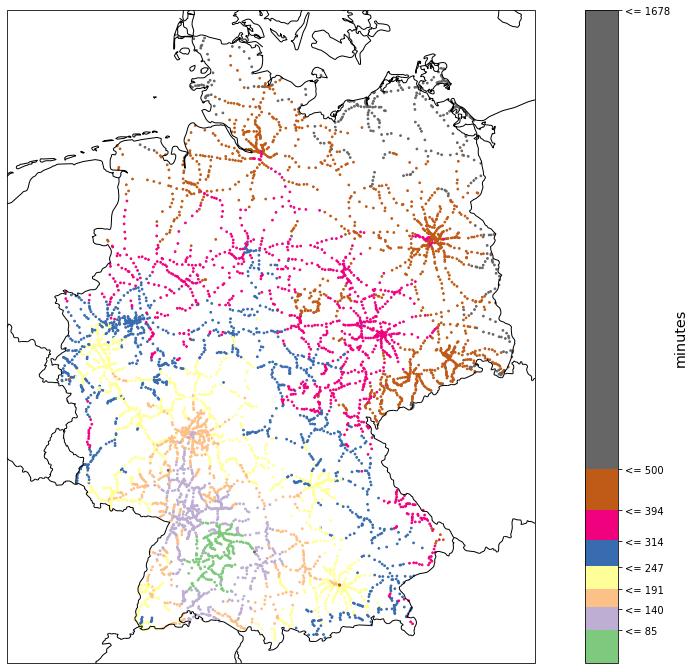

In [17]:
ax = plt.axes(projection=cartopy.crs.Mercator())
colors = qualitative_colors
ax.set_extent(germany_rectangle)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.COASTLINE)

cm = create_colormap_absolute(
    [(bound, color) for bound, color in zip(color_bounds, colors)] + [(maximum_travel_time, colors[-1])],
    maximum_travel_time,
    discret=True)
sc = plt.scatter(
    longitude_x, latitude_y, c=minimum_travel_time_z,
    s=point_size,
    vmin=minimum_travel_time, vmax=maximum_travel_time,
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)

plt.show()

# Assign clusters to coordinates

First we need to define the coordinates for which we want to calculate values for.

In [18]:
steps = 300
longitudes = np.linspace(germany_rectangle[2], germany_rectangle[3], steps)
latitudes = np.linspace(germany_rectangle[0], germany_rectangle[1], steps)
latitude_grid, longitude_grid = np.meshgrid(longitudes, latitudes)

In [19]:
latitude_grid

array([[47.1024877 , 47.12951317, 47.15653864, ..., 55.12905321,
        55.15607868, 55.18310415],
       [47.1024877 , 47.12951317, 47.15653864, ..., 55.12905321,
        55.15607868, 55.18310415],
       [47.1024877 , 47.12951317, 47.15653864, ..., 55.12905321,
        55.15607868, 55.18310415],
       ...,
       [47.1024877 , 47.12951317, 47.15653864, ..., 55.12905321,
        55.15607868, 55.18310415],
       [47.1024877 , 47.12951317, 47.15653864, ..., 55.12905321,
        55.15607868, 55.18310415],
       [47.1024877 , 47.12951317, 47.15653864, ..., 55.12905321,
        55.15607868, 55.18310415]])

In [20]:
np.dstack([longitude_grid, latitude_grid])

array([[[ 4.98865807, 47.1024877 ],
        [ 4.98865807, 47.12951317],
        [ 4.98865807, 47.15653864],
        ...,
        [ 4.98865807, 55.12905321],
        [ 4.98865807, 55.15607868],
        [ 4.98865807, 55.18310415]],

       [[ 5.02353546, 47.1024877 ],
        [ 5.02353546, 47.12951317],
        [ 5.02353546, 47.15653864],
        ...,
        [ 5.02353546, 55.12905321],
        [ 5.02353546, 55.15607868],
        [ 5.02353546, 55.18310415]],

       [[ 5.05841284, 47.1024877 ],
        [ 5.05841284, 47.12951317],
        [ 5.05841284, 47.15653864],
        ...,
        [ 5.05841284, 55.12905321],
        [ 5.05841284, 55.15607868],
        [ 5.05841284, 55.18310415]],

       ...,

       [[15.34724112, 47.1024877 ],
        [15.34724112, 47.12951317],
        [15.34724112, 47.15653864],
        ...,
        [15.34724112, 55.12905321],
        [15.34724112, 55.15607868],
        [15.34724112, 55.18310415]],

       [[15.3821185 , 47.1024877 ],
        [15.3821185 , 47.12

Secondly let us define a way to filter the coordinates outside germany.

In [21]:
germany_geometry = shapely.prepared.prep(shapely.ops.unary_union(
    list(cartopy.io.shapereader.Reader(germany_shape_path.as_posix()).geometries())))

def germany_contains(longitude, latitude):
    return germany_geometry.contains(shapely.geometry.Point(longitude, latitude))

In [22]:
germany_filter = ~np.apply_along_axis(lambda coordinate: germany_contains(*coordinate), axis=2, arr=np.dstack([longitude_grid, latitude_grid]))
germany_filter

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [23]:
def remove_non_german_coordinates(values):
    values[germany_filter] = np.nan
    return values

I think it would also be nice to see the borders of the german states.  
Thirdly let us define a way to render the borders of the german states.  

In [24]:
german_states_geometry = list(cartopy.io.shapereader.Reader(
    german_states_shape_path.as_posix()).geometries())
germany_geometry = list(cartopy.io.shapereader.Reader(
    germany_shape_path.as_posix()).geometries())

In [25]:
def add_german_states_borders(ax):
    ax.add_geometries(
        german_states_geometry,
        cartopy.crs.PlateCarree(),
        edgecolor='#242424',  #'black',
        linewidth=0.5,
        facecolor='None')


def add_germany_border(ax):
    ax.add_geometries(
        germany_geometry,
        cartopy.crs.PlateCarree(),
        edgecolor='#242424',
        linewidth=0.5,
        facecolor='None')

Now we will try to assign clusters to coordinates by using linear regression.  

In [26]:
model = sklearn.linear_model.LinearRegression().fit(
    np.array(list(zip(longitude_x, latitude_y))),
    minimum_travel_time_z)

In [27]:
latitude_longitude_grid = np.dstack([longitude_grid, latitude_grid])
latitude_longitude_list = latitude_longitude_grid.reshape((
    latitude_longitude_grid.shape[0] * latitude_longitude_grid.shape[1],
    latitude_longitude_grid.shape[2]))
travel_time_prediction = remove_non_german_coordinates(
    model.predict(latitude_longitude_list)
    .reshape(longitude_grid.shape))

In [28]:
travel_time_prediction

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [29]:
print(latitude_longitude_list[-1])
print([[latitude_grid[-1, -1], longitude_grid[-1, -1]]])
model.predict([[longitude_grid[-1, -1], latitude_grid[-1, -1]]])

[15.41699588 55.18310415]
[[55.183104153, 15.4169958839]]


array([663.70542179])

In [30]:
model.score(
    np.array(list(zip(longitude_x, latitude_y))),
    minimum_travel_time_z)

0.7496063575861487

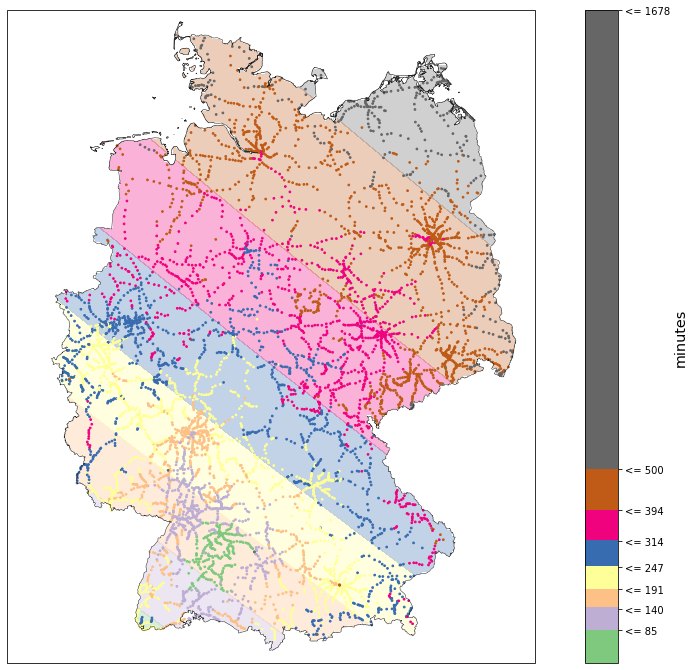

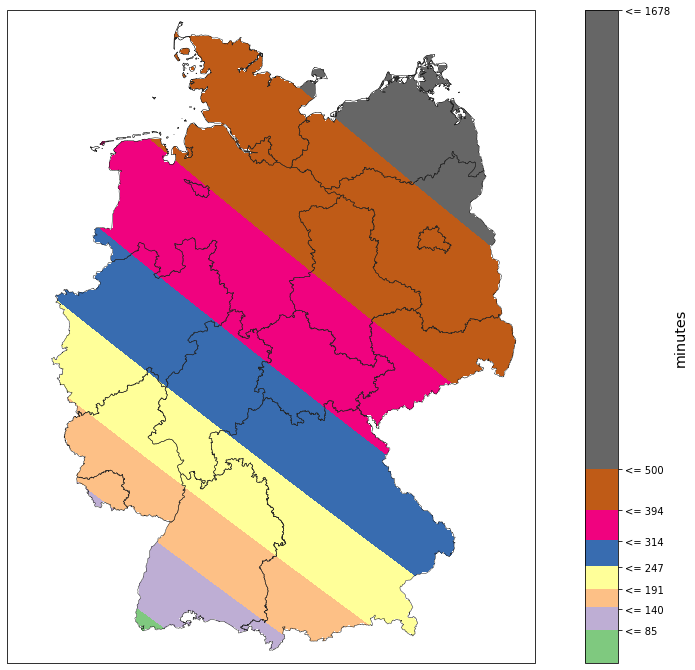

In [31]:
ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.COASTLINE)
add_germany_border(ax)

plt.contourf(longitude_grid, latitude_grid, travel_time_prediction,
             levels=color_bounds + [maximum_travel_time],
             cmap=cm,
             alpha=0.3,
             transform=cartopy.crs.PlateCarree())
plt.scatter(
    longitude_x, latitude_y, c=minimum_travel_time_z,
    s=point_size,
    vmin=minimum_travel_time, vmax=maximum_travel_time,
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)
plt.show()


ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.COASTLINE)
add_german_states_borders(ax)

plt.contourf(longitude_grid, latitude_grid, travel_time_prediction,
             levels=color_bounds + [maximum_travel_time],
             cmap=cm,
             transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)
plt.show()

Well, it seems like just using the latitude and longitude is not sufficient to predict the travel time.  
So let us use more information like the distance to "Tübingen HBF", the angle, ...

In [32]:
TUEBINGEN_HBF_LATITUDE = 48.515811
TUEBINGEN_HBF_LONGITUDE = 9.055407

def get_distance(dest_longitude, dest_latitude,
                 src_longitude=TUEBINGEN_HBF_LONGITUDE,
                 src_latitude=TUEBINGEN_HBF_LATITUDE):
    # credits: https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371e3  # metres
    φ1 = src_latitude * np.pi / 180  # φ, λ in radians
    φ2 = dest_latitude * np.pi / 180
    deltaφ = (dest_latitude-src_latitude) * np.pi / 180
    deltaλ = (dest_longitude-src_longitude) * np.pi / 180

    a = (np.sin(deltaφ / 2) * np.sin(deltaφ / 2) +
         np.cos(φ1) * np.cos(φ2) *
         np.sin(deltaλ/2) * np.sin(deltaλ/2))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return R * c  # in metres

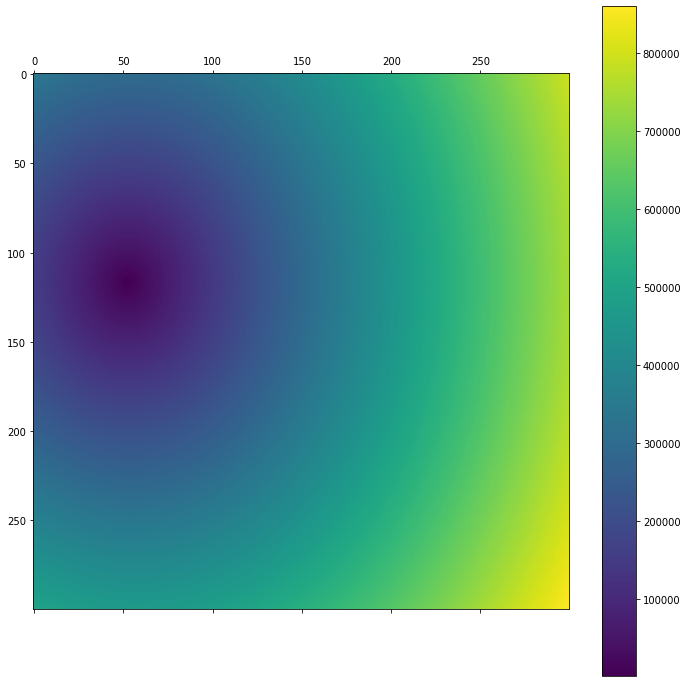

In [33]:
distance_list = get_distance(longitude_grid, latitude_grid)
distance_grid = distance_list.reshape(longitude_grid.shape)
sc = plt.matshow(distance_grid)
plt.colorbar(sc)

In [34]:
training_long = np.array(longitude_x)
training_lat = np.array(latitude_y)
training_distance = get_distance(training_long, training_lat)
training_distance_long = get_distance(training_long, np.repeat(TUEBINGEN_HBF_LATITUDE, len(latitude_y)))
training_distance_lat = get_distance(np.repeat(TUEBINGEN_HBF_LONGITUDE, len(longitude_x)), training_lat)
# fix the sign such that places below have the same sign and places above have the same sign
# (latitude corresponds to the y-coordinate -> ankathete)
training_distance_lat *= (
     1 * (training_lat >= TUEBINGEN_HBF_LATITUDE) +
    -1 * (training_lat < TUEBINGEN_HBF_LATITUDE))
# fix the sign such that places to the left have the same sign and places to the right have the same sign
# (longitude corresponds to the x-coordinate -> gegenkathete)
training_distance_long *= (
     1 * (training_long >= TUEBINGEN_HBF_LONGITUDE) +
    -1 * (training_long < TUEBINGEN_HBF_LONGITUDE))
training_angle = np.pi + np.arctan2(training_distance_long, training_distance_lat)
training_data = (
    np.stack([training_long,
              training_lat,
              training_distance,
              training_distance_long,
              training_distance_lat,
              training_angle * training_distance,],
             axis=1))
distance_model = sklearn.linear_model.LinearRegression(normalize=True).fit(
    training_data,
    minimum_travel_time_z)

In [35]:
test_long = longitude_grid.reshape(-1)
test_lat = latitude_grid.reshape(-1)
test_distance = distance_list.reshape(-1)
test_distance_long = get_distance(longitude_grid.reshape(-1), np.repeat(TUEBINGEN_HBF_LATITUDE, len(latitude_grid.reshape(-1))))
test_distance_lat = get_distance(np.repeat(TUEBINGEN_HBF_LONGITUDE, len(longitude_grid.reshape(-1))), latitude_grid.reshape(-1))
test_distance_lat *= (
     1 * (test_lat >= TUEBINGEN_HBF_LATITUDE) +
    -1 * (test_lat < TUEBINGEN_HBF_LATITUDE))
test_distance_long *= (
     1 * (test_long >= TUEBINGEN_HBF_LONGITUDE) +
    -1 * (test_long < TUEBINGEN_HBF_LONGITUDE))
test_angle = np.pi + np.arctan2(test_distance_long, test_distance_lat)
travel_time_prediction_by_distance = remove_non_german_coordinates(
    distance_model.predict(
        (np.stack(
            [test_long,
             test_lat,
             test_distance,
             test_distance_long,
             test_distance_lat,
             test_angle * test_distance,],
            axis=1)))
    .reshape(longitude_grid.shape))

In [36]:
distance_model.score(
    training_data,
    minimum_travel_time_z)

0.839222559949022

In [37]:
travel_time_prediction_by_distance

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

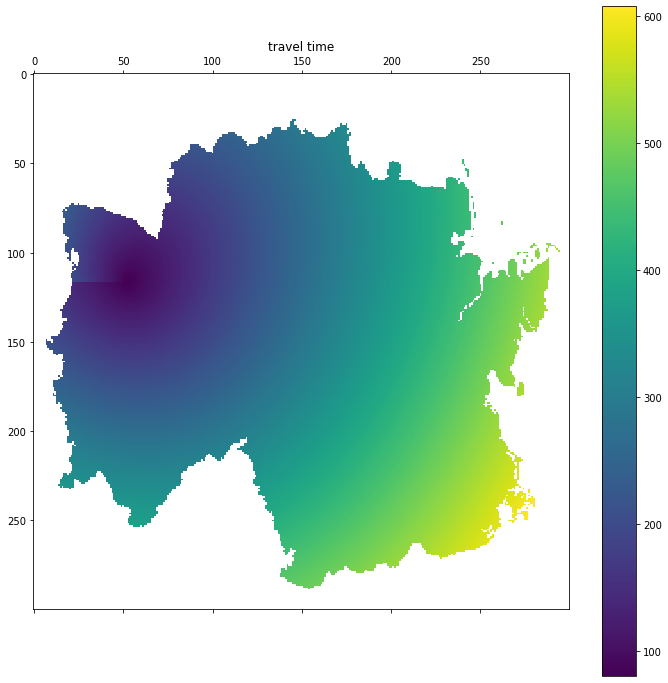

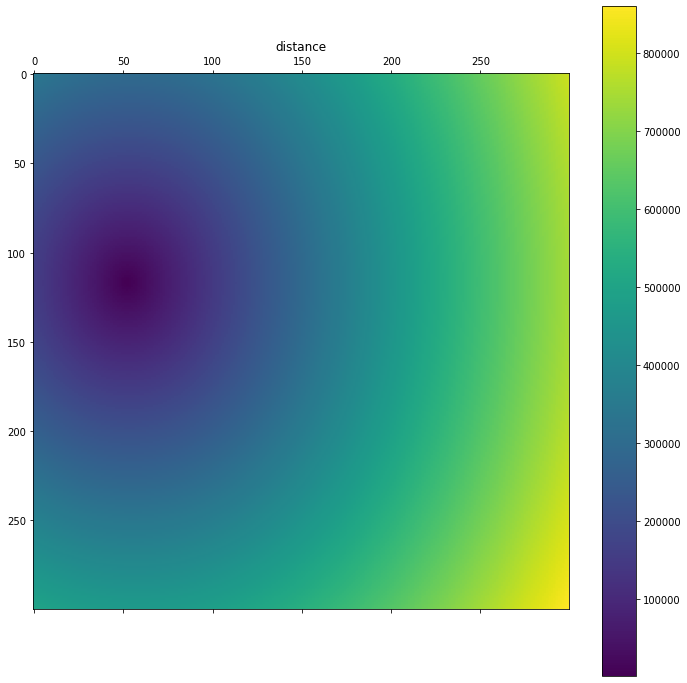

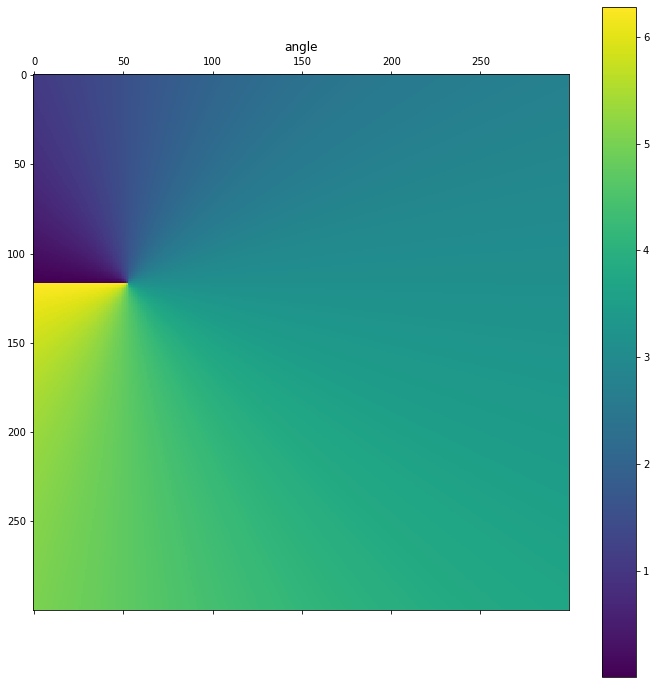

In [38]:
sc = plt.matshow(travel_time_prediction_by_distance)
plt.title('travel time')
plt.colorbar(sc)
sc = plt.matshow(distance_list.reshape(longitude_grid.shape))
plt.title('distance')
plt.colorbar(sc)
sc = plt.matshow(test_angle.reshape(longitude_grid.shape))
plt.title('angle')
plt.colorbar(sc)
#print(min(test_distance_long), max(test_distance_long))
#sc = plt.matshow(test_distance_long.reshape(longitude_grid.shape))
#plt.title('distance long')
#plt.colorbar(sc)
#print(min(test_distance_lat), max(test_distance_lat))
#sc = plt.matshow(test_distance_lat.reshape(longitude_grid.shape))
#plt.title('distance lat')
#plt.colorbar(sc)

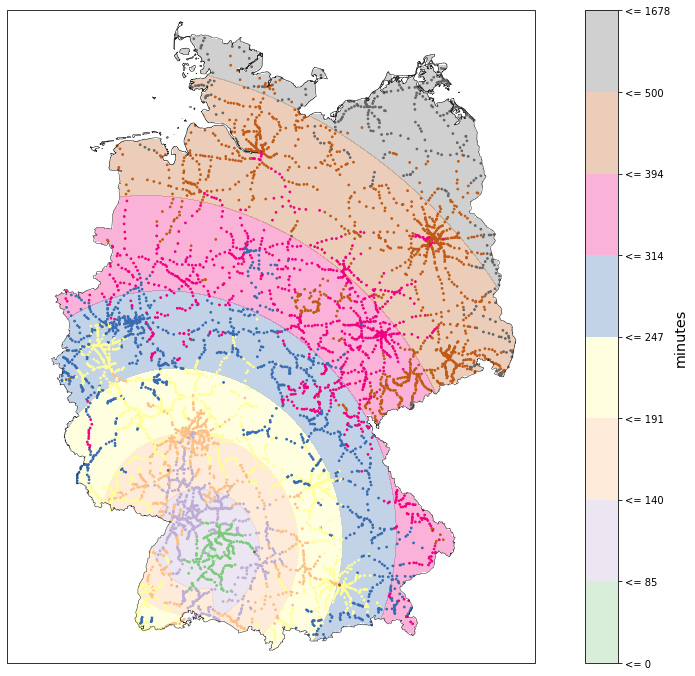

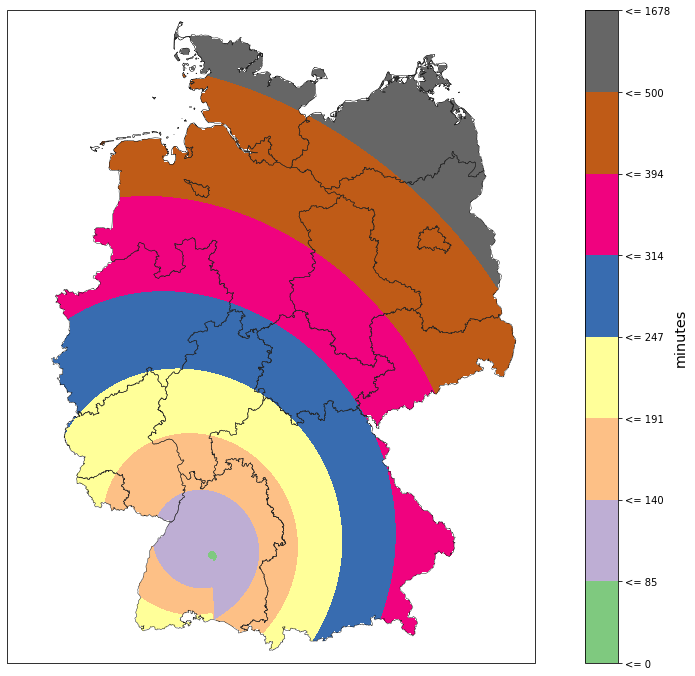

In [39]:
ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.COASTLINE)
add_germany_border(ax)

sc = plt.contourf(
    longitude_grid, latitude_grid, travel_time_prediction_by_distance,
    levels=color_bounds + [maximum_travel_time],
    cmap=cm,
    alpha=0.3,
    transform=cartopy.crs.PlateCarree())
plt.scatter(
    longitude_x, latitude_y, c=minimum_travel_time_z,
    s=point_size,
    vmin=minimum_travel_time, vmax=maximum_travel_time,
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)
plt.show()

ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.COASTLINE)
add_german_states_borders(ax)

sc = plt.contourf(
    longitude_grid, latitude_grid, travel_time_prediction_by_distance,
    levels=color_bounds + [maximum_travel_time],
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)
plt.show()

Well, if we ignore the green category then the last linear regression actually achieved a result which is not too bad.  
However.. nearly all green points have the wrong color.  
So let us try to improve the result by searching for linear functions for different ranges of angles.  
For this let us calculate the cdf and ppf of our samples so we can search for angle ranges for which a random element of our samples has the same likelihood to belong to any of them.  
So there should be about the same amount of sample elements in each of these angle ranges.  
So we should not face a problem like range A contains only a single sample and therefore the linear regression will calculate complete nonsense.  

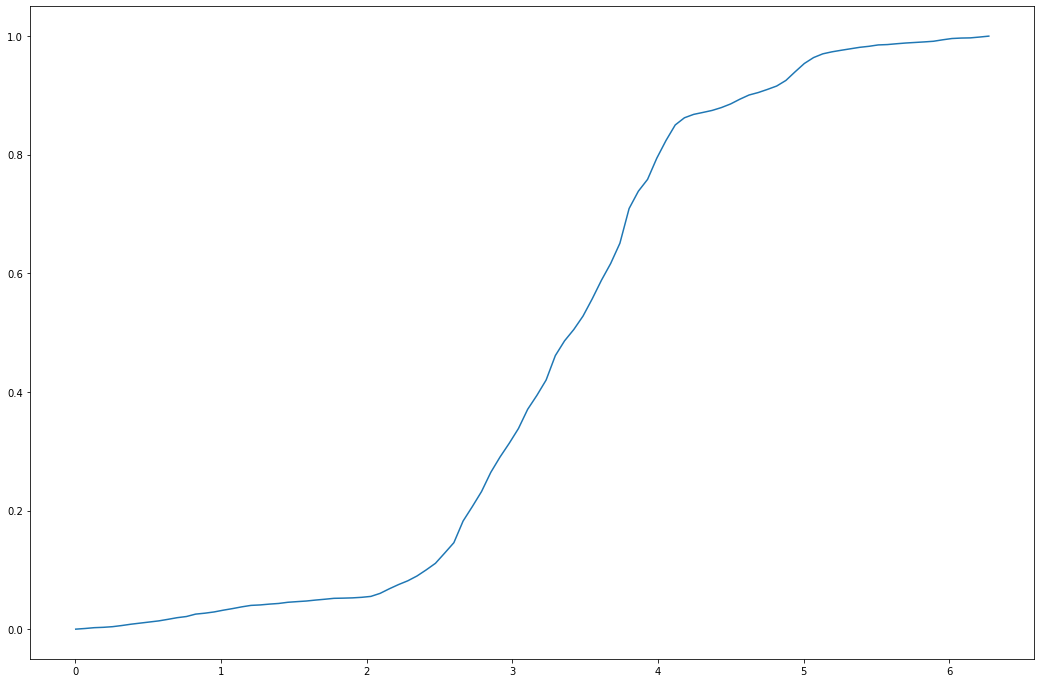

In [40]:
angle_min = min(training_angle)
angle_max = max(training_angle)
angle_X = np.linspace(angle_min, angle_max, 100)
angle_hist = scipy.stats.rv_histogram(np.histogram(training_angle, bins=len(training_angle)))
# plt.hist(training_angle, density=True, bins=1000)
# plt.hist(training_distance_lat)
plt.plot(angle_X, angle_hist.cdf(angle_X))

In [41]:
points_per_angle_range = 60
angle_range_share = points_per_angle_range / len(training_angle)
angle_total_bounds = int(1 / angle_range_share)
angle_bounds = [
    angle_hist.ppf(i * angle_range_share)
    for i in range(1, angle_total_bounds)]
angle_ranges = [
    # exclusive, inclusive
    (lower_bound, upper_bound)
    for lower_bound, upper_bound
    in zip([angle_min - 0.1] + angle_bounds, angle_bounds + [angle_max])]
angle_ranges[0:10], len(angle_ranges)

([(-0.09790536305651446, 0.42009311405518773),
  (0.42009311405518773, 0.6756443871849638),
  (0.6756443871849638, 0.9166481495103881),
  (0.9166481495103881, 1.1300116413075452),
  (1.1300116413075452, 1.5247341011322848),
  (1.5247341011322848, 2.040200900633144),
  (2.040200900633144, 2.1274859654592535),
  (2.1274859654592535, 2.2123464451513044),
  (2.2123464451513044, 2.3038341242097817),
  (2.3038341242097817, 2.3670349767042427)],
 107)

We will only use the distance to calculate the travel time as it looks like overfitting happens  
if we use all the parameters of the last (single) linear regression model.  
(To be more detailed:  
Using the parameters training_long, training_lat, training_distance, training_distance_long, training_distance_lat and training_angle * training_distance  
leads to at least one badly fitted function as white points are visible in the green cluster.  
Using the parameters training_distance, training_distance_long, training_distance_lat and training_angle * training_distance  
leads to at least one overfitted function as some lines of the yellow cluster suddenly reach the end of germany.)

avg score 0.8495264668334676
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


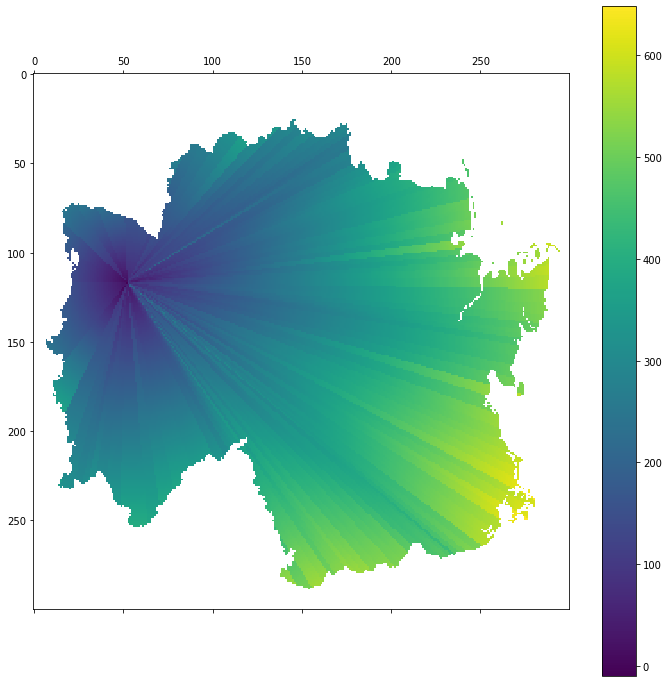

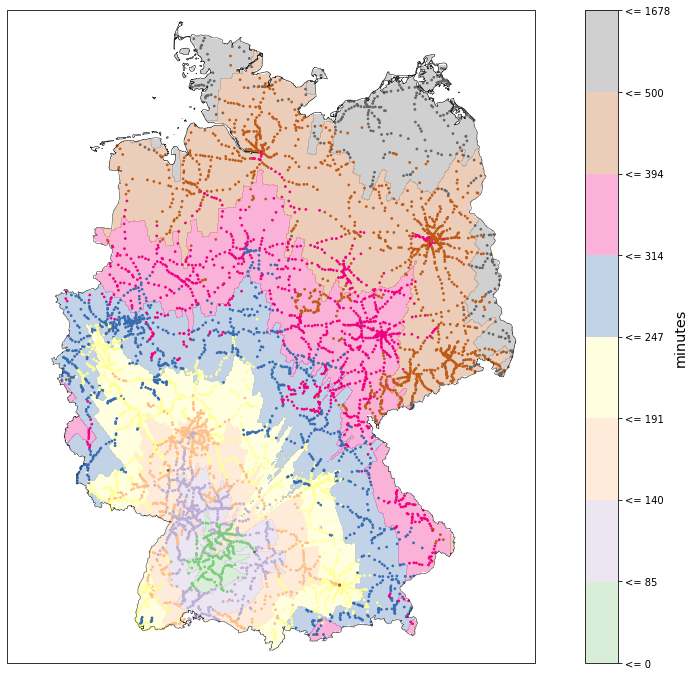

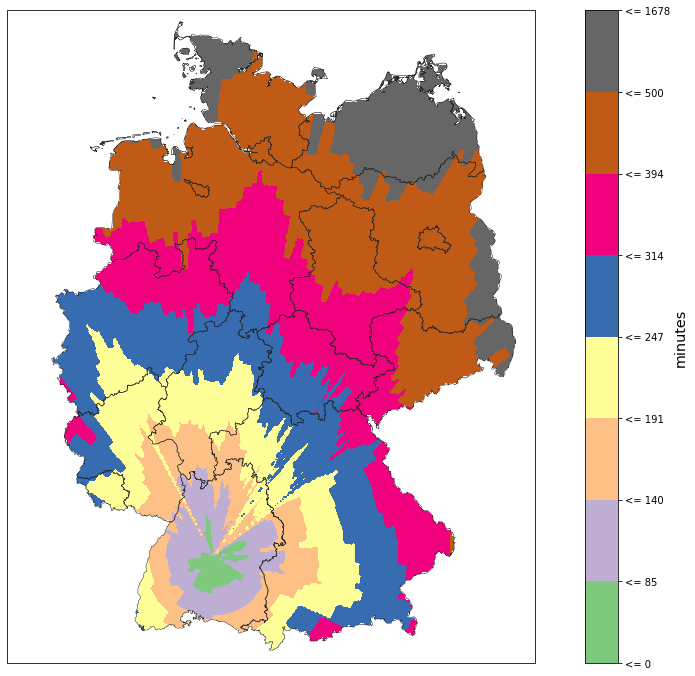

In [42]:
travel_time_prediction_by_distance = np.zeros_like(test_long)
score_sum = 0
scores_total = 0
np_minimum_travel_time_z = np.array(minimum_travel_time_z)


for lower_bound, upper_bound in angle_ranges:
    training_selection = (
        (lower_bound < training_angle) &
        (training_angle <= upper_bound))
    if not np.any(training_selection):
        continue
    # training_X = training_distance[training_selection].reshape(-1, 1)
    training_X = (
        np.stack([
            #training_long[training_selection],
            #training_lat[training_selection],
            training_distance[training_selection],
            #training_distance_long[training_selection],
            #training_distance_lat[training_selection],
            #training_angle[training_selection] * training_distance[training_selection]
            ], axis=1))
    training_Y = np_minimum_travel_time_z[training_selection]
    distance_model = sklearn.linear_model.LinearRegression(normalize=True).fit(
        training_X,
        training_Y)

    score = distance_model.score(
        training_X,
        training_Y)
    score_sum += score
    scores_total += 1

    test_selection = (
        (lower_bound < test_angle) &
        (test_angle <= upper_bound))
    # test_X = test_distance[test_selection].reshape(-1, 1)
    test_X = (
        np.stack([
            #test_long[test_selection],
            #test_lat[test_selection],
            test_distance[test_selection],
            #test_distance_long[test_selection],
            #test_distance_lat[test_selection],
            #test_angle[test_selection] * test_distance[test_selection],
            ], axis=1))
    travel_time_prediction_by_distance[test_selection] = (
        distance_model.predict(
            test_X))


travel_time_prediction_by_distance = (
    remove_non_german_coordinates(
        travel_time_prediction_by_distance
        .reshape(longitude_grid.shape)))
print('avg score', score_sum / scores_total)
print(travel_time_prediction_by_distance)
sc = plt.matshow(travel_time_prediction_by_distance.reshape(longitude_grid.shape))
plt.colorbar(sc)
plt.show()

ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.COASTLINE)
add_germany_border(ax)

sc = plt.contourf(
    longitude_grid, latitude_grid,
    travel_time_prediction_by_distance,
    levels=color_bounds + [maximum_travel_time],
    cmap=cm,
    alpha=0.3,
    transform=cartopy.crs.PlateCarree())
plt.scatter(
    longitude_x, latitude_y, c=minimum_travel_time_z,
    s=point_size,
    vmin=minimum_travel_time, vmax=maximum_travel_time,
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)
plt.show()



ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.COASTLINE)
add_german_states_borders(ax)
sc = plt.contourf(
    longitude_grid, latitude_grid,
    travel_time_prediction_by_distance,
    levels=color_bounds + [maximum_travel_time],
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)
plt.show()

I think that is a good improvement compared to the last model which used only a single linear regression.  
**Just a thought** but maybe it is possible to improve it by weighting the points of an angle area by their distance distribution  
such that we have a normal distribution for the distances.  
I think this could help to remove the yellow outliner line in the gray and orange area.  

Now as a last try let us use k nearest neighbors to model the travel time.  
For this we just try to assign a coordinate one of the time ranges.  

In [43]:
training_X = np.stack(
    [training_long,
     training_lat],
    axis=1)
training_Y = sum(
    (i+1) * ((lower_bound < np_minimum_travel_time_z) & (np_minimum_travel_time_z <= upper_bound))
    for i, (lower_bound, upper_bound) in enumerate(zip(color_bounds, color_bounds[1:] + [maximum_travel_time])))
nearest_neighbors_model = sklearn.neighbors.KNeighborsClassifier().fit(
    training_X,
    training_Y)

In [44]:
travel_time_categories_prediction = (
    nearest_neighbors_model.predict(
        np.stack(
            [test_long,
             test_lat],
            axis=1))
    .reshape(longitude_grid.shape))

In [45]:
travel_time_prediction_by_distance = np.zeros_like(travel_time_prediction_by_distance)
for i, bound in enumerate(color_bounds + [maximum_travel_time]):
    travel_time_prediction_by_distance += (
        (color_bounds + [maximum_travel_time])[i] *
        (travel_time_categories_prediction == i))

In [46]:
travel_time_prediction_by_distance = remove_non_german_coordinates(travel_time_prediction_by_distance)

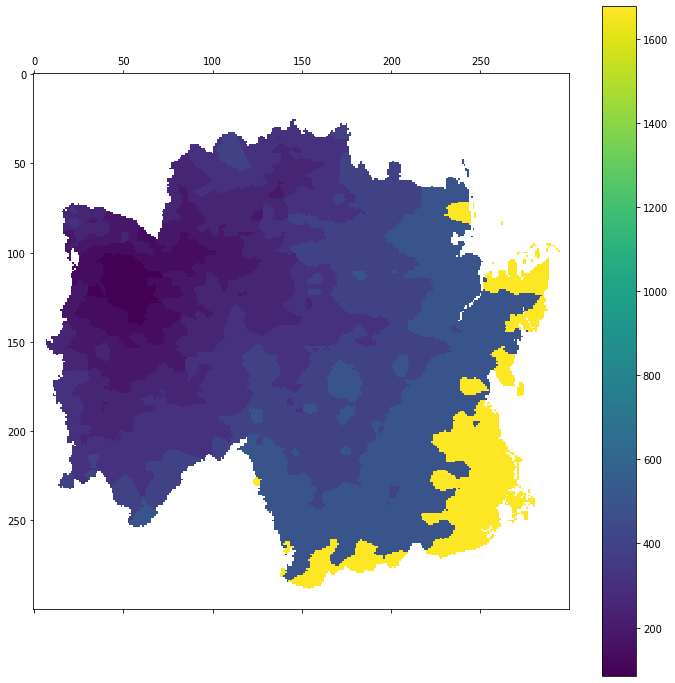

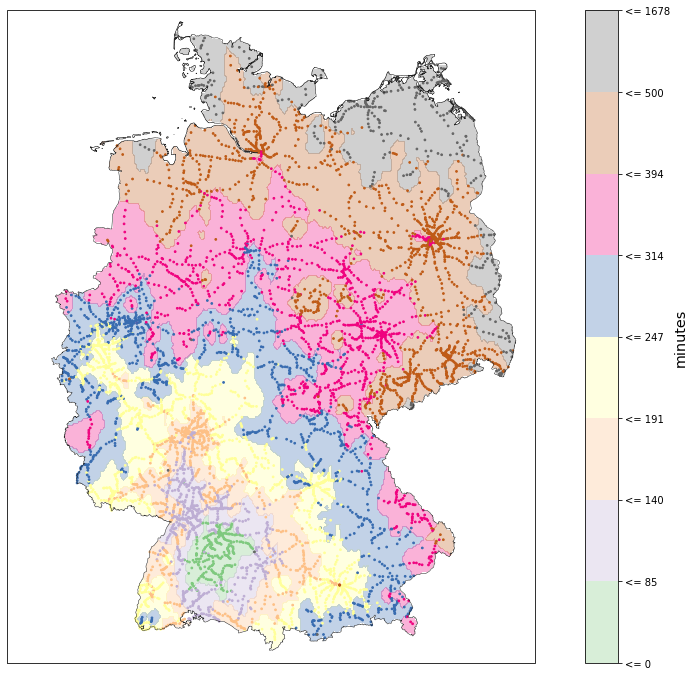

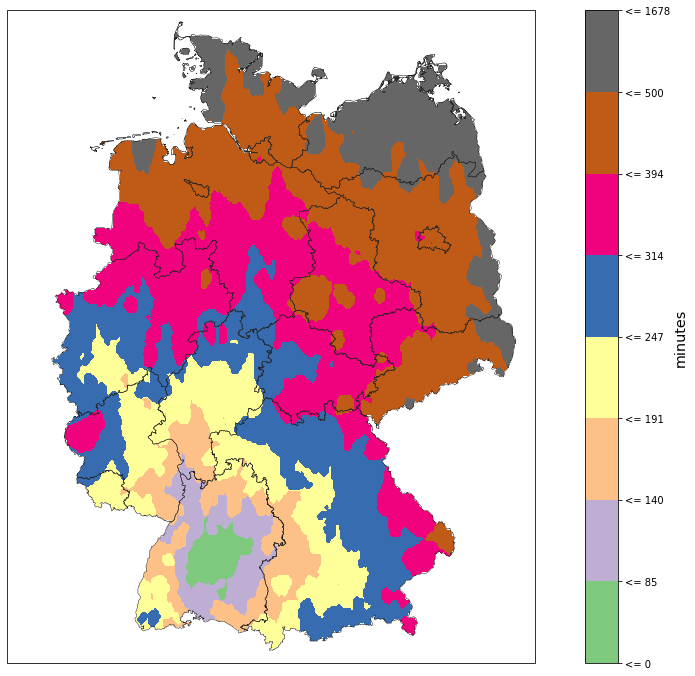

In [47]:
sc = plt.matshow(travel_time_prediction_by_distance.reshape(longitude_grid.shape))
plt.colorbar(sc)
plt.show()

ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.COASTLINE)
add_germany_border(ax)

sc = plt.contourf(
    longitude_grid, latitude_grid,
    travel_time_prediction_by_distance,
    levels=color_bounds + [maximum_travel_time],
    cmap=cm,
    alpha=0.3,
    transform=cartopy.crs.PlateCarree())
plt.scatter(
    longitude_x, latitude_y, c=minimum_travel_time_z,
    s=point_size,
    vmin=minimum_travel_time, vmax=maximum_travel_time,
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)
plt.show()



ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.COASTLINE)
add_german_states_borders(ax)
sc = plt.contourf(
    longitude_grid, latitude_grid,
    travel_time_prediction_by_distance,
    levels=color_bounds + [maximum_travel_time],
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)
plt.show()